In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import os
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
from itertools import chain
from tqdm.autonotebook import tqdm
import numpy as np
from torch import optim

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(64)])

batch_size = 128

In [3]:
images = ImageFolder('.\data\shapes3dtrain', transform=transform)

In [4]:
trainloader = torch.utils.data.DataLoader(images, batch_size=batch_size, shuffle=True, num_workers=0)

torch.Size([3, 64, 64])


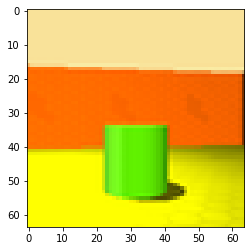

In [6]:
train_features = next(iter(trainloader))
img = train_features[0][0]
print(img.shape)
plt.imshow(img.swapaxes(0,1).swapaxes(1,2))

In [ ]:
ind = 0
test_features= next(iter(trainloader))
# print(f"Feature batch shape: {test_features.size()}")
# print(f"Labels batch shape: {test_labels.size()}")
img1 = test_features[ind][0]#.unsqueeze(0)
# label1 = test_labels[ind]
print(img1.shape)
plt.imshow(img1.swapaxes(0,1).swapaxes(1,2))

In [14]:
class FiLMBlock(nn.Module):
    def __init__(self, out_channels = None):
        super(FiLMBlock, self).__init__()
        self.out_channels = out_channels
        self.mu = nn.Linear(256, out_channels)
        self.sigma = nn.Linear(256, out_channels)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        mu = self.mu(x)
        sigma = self.sigma(x)
        return self.activation(mu), self.activation(sigma)

In [15]:
class FiLMImplement(nn.Module):
    def __init__(self, window):
        super(FiLMImplement, self).__init__()
        self.window = window

    def broadcast_2d(self, x):
        return torch.broadcast_to(x, (self.window, self.window))

    def forward(self, x, mu, sigma):
        mu_broadcast = torch.stack(tuple(map(self.broadcast_2d, mu.squeeze(0))), dim=0)
        sigma_broadcast = torch.stack(tuple(map(self.broadcast_2d, sigma.squeeze(0))), dim=0)
        x = sigma_broadcast * x + mu_broadcast
        return x

In [16]:
# final
class Encoder(nn.Module):
    '''
    simple encoder with a single hidden dense layer (ReLU activation)
    and linear projections to the diag-Gauss parameters
    '''
    def __init__(self, latent_size=20, nc=3):
        super(Encoder, self).__init__()
        self.latent_size = latent_size
        self.nc = nc

        self.film1 = FiLMBlock(8)
        self.film2 = FiLMBlock(16)
        self.film3 = FiLMBlock(32)
        self.film4 = FiLMBlock(64)
        self.filmimp1 = FiLMImplement(31)
        self.filmimp2 = FiLMImplement(15)
        self.filmimp3 = FiLMImplement(7)
        self.filmimp4 = FiLMImplement(3)

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=2, padding=0)
        self.conv2 = nn.Conv2d(8, out_channels=16, kernel_size=3, stride=2, padding=0)
        self.conv3 = nn.Conv2d(16, out_channels=32, kernel_size=3, stride=2, padding=0)
        self.conv4 = nn.Conv2d(32, out_channels=64, kernel_size=3, stride=2, padding=0)
        # self.conv5 = nn.Conv2d(32, out_channels=64, kernel_size=3, stride=2, padding=1)
        # self.conv6 = nn.Conv2d(64, out_channels=64, kernel_size=3, stride=1, padding=1)

        self.enc_linear = nn.Sequential(
                nn.Linear(576, 256),
                nn.LeakyReLU(),
                nn.Linear(256, 20),
                nn.LeakyReLU())
        
        self.fc_mu = nn.Linear(20, latent_size)
        self.fc_var = nn.Linear(20, latent_size)

    def forward(self, x, helo=None):
        # block 1
        x = self.conv1(x)
        mu, sigma = self.film1( helo )
        x = self.filmimp1(x, mu, sigma)
        x = F.leaky_relu(x)
        
        
        x = self.conv2(x)
        mu2, sigma2 = self.film2( helo )
        x = self.filmimp2(x, mu2, sigma2)
        x = F.leaky_relu(x)

        #block 2
        x = self.conv3(x)
        mu3, sigma3 = self.film3( helo )
        x = self.filmimp3(x, mu3, sigma3)
        x = F.leaky_relu(x)
        
        x = self.conv4(x)
        mu4, sigma4 = self.film4( helo )
        x = self.filmimp4(x, mu4, sigma4)
        x = F.leaky_relu(x)
        x = x.view(x.shape[0], -1)
        x = self.enc_linear(x)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)

        return mu, log_var


In [17]:
# final
class Decoder(nn.Module):
    '''
    simple decoder: single dense hidden layer (ReLU activation) followed by 
    output layer with a sigmoid to squish values
    '''
    def __init__(self, latent_size=20, nc=3):
        super(Decoder, self).__init__()
        self.latent_size = latent_size
        self.nc = nc
        self.decoder_input = nn.Sequential(
            nn.Linear(latent_size, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 1024),
            nn.LeakyReLU(),
        )

        self.activation = nn.Sigmoid()

        self.film1U = FiLMBlock(64)
        self.film2U = FiLMBlock(32)
        self.film3U = FiLMBlock(16)
        self.film4U = FiLMBlock(8)
        self.filmimp1U = FiLMImplement(6)
        self.filmimp2U = FiLMImplement(9)
        self.filmimp3U = FiLMImplement(16)
        self.filmimp4U = FiLMImplement(31)

        self.conv1U = nn.ConvTranspose2d(64, out_channels=64, kernel_size=3, stride=2, padding=2, output_padding=1)
        self.conv2U = nn.ConvTranspose2d(64, out_channels=32, kernel_size=3, stride=2, padding=2, output_padding=0)
        self.conv3U = nn.ConvTranspose2d(32, out_channels=16, kernel_size=3, stride=2, padding=2, output_padding=1)
        self.conv4U = nn.ConvTranspose2d(16, out_channels=8, kernel_size=3, stride=2, padding=1, output_padding=0)
        self.conv5U = nn.ConvTranspose2d(8, out_channels=3, kernel_size=3, stride=2, padding=0, output_padding=1)
        #         self.conv6U = nn.ConvTranspose2d(16, out_channels=3, kernel_size=3, stride=1, padding=1, output_padding=0)
    
    def forward(self, x , helo=None):
        x = self.decoder_input(z)
        x = x.view(-1, 64, 4, 4)

        # block 1
        x = self.conv1U(x)
        mu11, sigma11 = self.film1U( helo )
        x = self.filmimp1U(x, mu11, sigma11)
        x = F.leaky_relu(x)
        
        x = self.conv2U(x)
        mu22, sigma22 = self.film2U( helo )
        x = self.filmimp2U(x, mu22, sigma22)
        x = F.leaky_relu(x)

        # block 2
        x = self.conv3U(x)
        mu33, sigma33 = self.film3U( helo )
        x = self.filmimp3U(x, mu33, sigma33)
        x = F.leaky_relu(x)
        
        x = self.conv4U(x)
        mu44, sigma44 = self.film4U( helo )
        x = self.filmimp4U(x, mu44, sigma44)
        x = F.leaky_relu(x)
        
        # block 3
        x = self.conv5U(x)
        return self.activation(x)



In [12]:
def sample(mu, logvar):
    std = torch.exp(0.5*logvar)  # e^(1/2 * log(std^2))
    eps = torch.randn_like(std)  # random ~ N(0, 1)
    return eps.mul(std).add_(mu)

In [10]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [18]:
# build the model and load state
enc = Encoder()
enc.load_state_dict(torch.load('C:/Users/Hanu/Downloads/weight_save/encshapes3Dyoto.weights', map_location=torch.device('cpu')))

dec = Decoder()
dec.load_state_dict(torch.load('C:/Users/Hanu/Downloads/weight_save/decshapes3Dyoto.weights', map_location=torch.device('cpu')))

# put model in eval mode
enc = enc.eval() 
dec = dec.eval() 

torch.Size([3, 64, 64])


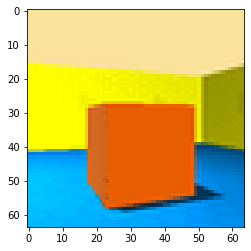

In [19]:
ind = 0
test_features= next(iter(trainloader))
# print(f"Feature batch shape: {test_features.size()}")
# print(f"Labels batch shape: {test_labels.size()}")
img1 = test_features[ind][0]#.unsqueeze(0)
# label1 = test_labels[ind]
print(img1.shape)
plt.imshow(img1.swapaxes(0,1).swapaxes(1,2))

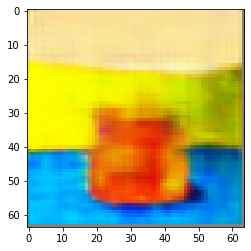

In [23]:
beta = float(512)
beta2 = torch.tensor([1*beta], requires_grad=False)
beta2 = torch.broadcast_to(beta2, (1, 256))


mu, log_sigma2 = enc(img1.unsqueeze(0), beta2)
z = sample(mu, log_sigma2)
outp = dec(z, beta2)
out = outp[0].cpu().detach().numpy()
plt.imshow(out.swapaxes(0,1).swapaxes(1,2))

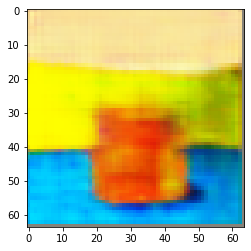

In [32]:
beta = float(512)
beta2 = torch.tensor([1*beta], requires_grad=False)
beta2 = torch.broadcast_to(beta2, (1, 256))


mu, log_sigma2 = enc(img1.unsqueeze(0), beta2)
z = sample(mu, log_sigma2)
outp = dec(z, beta2)
out = outp[0].cpu().detach().numpy()
plt.imshow(out.swapaxes(0,1).swapaxes(1,2))